# Aufgabe für die Projektgruppe 6

Bearbeiten Sie die folgende Aufgabe:

Ihr Auftraggeber ist eine Familie, welche eine Beratung von Ihnen benötigt. Sie besitzt ein kleines altes Windrad, welches nur für den Eigenverbrauch genutzt wird sowie eine PV Anlage. Die Familie möchte von Ihnen wissen, ob Sie Kosten durch die Investition in verschiedene Komponenten ihres Energiesystems einsparen kann. 

Nehmen Sie dabei die folgenden Angaben an:
* Nennleistung der Windernergieanlage: 5 kW (Keine EEG- Vergütung)
* Nennleistung der PV-Anlage 9 kWp (70% Kappungsgrenze berücksichtigen)
* Die Anschlussleistung an das elektrische Netz beträgt 15 kW
* Die Heizleistung des Erdgaskessel liegt bei 20 kW, der Wirkungsgrad ist 99%
* Erdgaspreis: 7 cent/kWh
* Strompreis: 30 cent/kWh
* EEG-Vergütung PV Anlage: 12,30 cent/kWh

Prüfen und kombinieren Sie mindestens drei der unten aufgeführten Optionen und bewerten Sie diese nach ihrer wirtschaftlicher Vorteilhaftigkeit. Unter den gewählten Optionen sollte sich mindestens eine der beiden Optionen BHKW oder Wärmepumpe befinden:
- Implementierung eines Heizstabes mit annuitätische Kosten von 50€ (Elektrische Leistung 5 kW, Wirkungsgrad 98%) 
- Installation eines BHKWs mit annuitätische Kosten von 1.200€ (Elektrische Leistung 1kW, elektrischer Wirkungsgrad 16%, Thermischer Wirkungsgrad 80%, nehmen Sie eine feste Stromkennzahl von 0,2 an, ein Beispiel für die Implementierung eines BHKWs in PyPSA finden Sie hier: https://pypsa.org/examples/chp-fixed-heat-power-ratio.html. Eine KWK-Vergütung müssen Sie nicht implementieren, da hier die pauschalierte Zuschlagzahlung gewählt wird.)
- Beschaffung einer elektrischen Batterie mit annuitätische Kosten von 900€ (8kWh Kapazität, 2,4 kW Speicher und Ladeleistung, einem Gesamtwirkungsgrad von 85%, keine Selbstentladungsverluste) 
- Erweiterung des Heizungssystems um einen thermischen Speicher mit annuitätische Kosten von 100€ (7kWh Kapazität und eine Ein und Ausspeicherleistung von 12 kW, keine Selbstentladungsverluste)
- Implementierung einer selbst gewählten Wärmepumpe. Hier müssen Sie nach geeigneten Daten zu Leistungen, Kosten und Performance recherchieren. Sie dürfen dabei die Jahresarbeitszahl als konstanten COP annehmen. Gehen Sie weiter davon aus, dass der Annuitätenfaktor für eine solche Investition bei 0,117 liegt.

1) Formulieren Sie die Optimierungsaufgabe
2) Skizzieren Sie das heutige System und bestimmen Sie die Kosten.
3) Skizzieren Sie mögliche Erweiterungen und bestimmen Sie die Kosten.
4) Interpretieren Sie die ihre Ergebnisse und ziehen Sie Schlussfolgerungen.
5) Bestimmen Sie die Grenzen Ihrer Modellierung und begründen Sie, ob die Ergebnisse trotz der Beschränkungen valide sind.

Der Import der Lastzeitreihen und der Einspeisezeitreihen ist unten schon vorbereitet. Diese repräsentieren das Jahr 2018 in stündlicher Auflösung. Nutzen Sie das in der Übung besprochene JupyterNotebook und schauen Sie sich die Funktionen und den Code dort an, um Ihr Energiesystem aufzubauen, es zu simulieren und auszuwerten.  

# Import <a class="anchor" id="chapter1"></a>

## Import der benötigten Python Module <a class="anchor" id="section_1_1"></a>

In [1]:
import pypsa
import pandas as pd
import math
import numpy as np

## Import der Daten <a class="anchor" id="section_1_2"></a>

Die Werte der Zeitreihen sind in einem Unterordner "data" als csv-Datein abgelegt. Sie bilden das Jahr 2019 ab und werden mithilfe des Python Moduls pandas eingelesen und als Variablen angelegt. Dabei werden Parameter wie der Separator (hier ";") und die Indexspalte sowie die Funktion, aus der Indexspalte Zeit und Datenformate auszulesen gesetzt.

In [2]:
pv_infeed = pd.read_csv('./data/pv_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)
wind_infeed = pd.read_csv('./data/wind_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)

In [3]:
electrical_load = pd.read_csv('./data/SumProfiles_3600s.Electricity.csv', sep = ';', index_col='time', parse_dates=True)
thermal_load = pd.read_csv('./data/SumProfiles_3600s.Gas.csv', sep = ';', index_col='time', parse_dates=True)


Die eingelesenen Zeitreihen sind so noch nicht vollständig nutzbar. Um die Einspeisung der Wind und PV-Anlage zu normieren wird eine neue Spalte mit dem normierten Leistungsoutput sowie neue Spalten mit der Leistung der Last in den jeweiligen Variablen angelegt.

In [4]:
#Die gemessene PV-Einspeiseganglinie ist von einer Anlage mit einer Leistung von 9 kWp, die der Windenergieanlage mit 5 kW.
pv_infeed['p_max_pu'] = pv_infeed.electricity/9 
wind_infeed['p_max_pu'] = wind_infeed.electricity/5 


Um einen kurzen Einblick in die Daten zu erhalten, schauen wir uns alle vier Tabellen an:

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

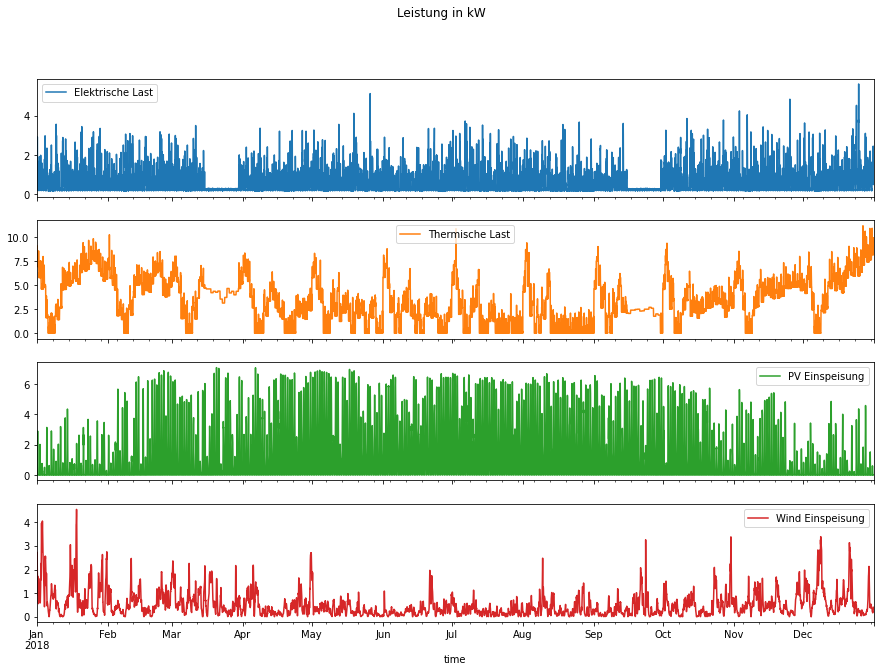

In [5]:
df_figure = pd.concat([electrical_load.sum_kwh, thermal_load.sum_kwh, pv_infeed.electricity,wind_infeed.electricity], axis = 1)
df_figure.columns = ['Elektrische Last', 'Thermische Last', 'PV Einspeisung', 'Wind Einspeisung']
df_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = True, figsize=(15,10), title= 'Leistung in kW')

# Optimierungsaufgabe

Ziel dieser Simulation ist die Überprüfung der Wirtschaftlichkeit für eine Investition in unterschiedliche Komponente. Dabei wird die Investition in eine Wärmepumpe, sowie in einen thermischen Speicher und in einen Batteriespeicher überprüft.
Es wird so vorgegangen, dass zunächst das Basissystem über ein Jahr simuliert wird. Daraus werden die jährlichen Kosten und Erlöse bestimmt. 
Anschließend wird dem System jeweils eine neue Komponente hinzugefügt und die Ergebnisse für die Kosten verglichen. Zuletzt wird ein System mit allen drei Komponenten untersucht.

# Basiskonfiguration

### Skizze der Basiskonfiguration
<img src="image/base_system.png">
Abb. 1

## Definition der Variablen und Objekte

In [6]:
#PV-Anlage
pv = {"electrical_power": 9.0}

#Windanlage
wind = {"electrical_power": 5.0}

#Heizkessel
heating_boiler = {"thermal_power": 20.0,
                   "efficiency":0.99,# Effizienz als normierte Kennzahl
                   "gas_costs": 7} #Kosten in cent/kWh

#Leistungsbezug aus dem Netz
grid_import = {"electrical_power" : 15,
                "electricity_price": 30.0} #Preise in cent/kWh    

#Leistungsabgabe in das Netz
grid_export = {"electrical_power" : 0.7 * pv["electrical_power"], #Repräsentiert die 70% Kappungsgrenze bei kleinen PV-Anlagen
                "electricity_revenue": 12.30} #EEG-Erlöse in cent/kWh




## Erstellung des Netzwerkes

In [7]:
#Netzwerk definieren
network = pypsa.Network()
network.set_snapshots(pv_infeed.index)
network.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 10 Minuten also 1/6 Stunde.

#Stromknoten definieren
network.add("Bus", 
            name = "electricity")

#Wärmeknoten definieren
network.add("Bus", 
            name = "thermal")

#Elektrische Last
network.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)

#Thermische last
network.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)

#PV-Anlage
network.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Windanlage
network.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])

#Netzbezug
network.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

#Netzeinspeisung
network.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.


## Simulation der Basiskonfiguration

In [8]:
network.lopf(solver_name = "cbc", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 0.79s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.94e+04


('ok', 'optimal')

## Auswertungsfunktion

In [9]:
#Auswertung der Kosten und Anteile
def cost_share_evaluation(network):
    '''
    This function evaluate the solved PyPSA network to get the costs, revenues and the share of the selfconsumption.
    
    Parameters
    ----------
    network:            PyPSA Network
                        The solved PyPSA network with all corresponding devices
    Returns
    -------
    results :           dict
                        The dictionary with all the results.
    '''
    
    grid_import = (network.generators_t.p['grid_import'] * network.snapshot_weightings).sum()
    grid_export = (network.generators_t.p['grid_export'] * network.snapshot_weightings).sum()
    self_consumed_pv = (network.generators_t.p['pv'] * network.snapshot_weightings).sum()- grid_export
    self_consumed_wind = (network.generators_t.p['wind']* network.snapshot_weightings).sum()
    self_consumption_ratio = (self_consumed_pv + self_consumed_wind)/(grid_import + self_consumed_pv + self_consumed_wind)
    
    electricity_cost = grid_import * network.generators.marginal_cost['grid_import']
    electricty_revenues = grid_export * network.generators.marginal_cost['grid_export']
    gas_costs = (network.generators_t.p['boiler']*network.snapshot_weightings).sum() * network.generators.marginal_cost['boiler']
    
    curtailment = ((network.generators_t.p_max_pu['pv']*network.generators.p_nom['pv'] - network.generators_t.p['pv'])*network.snapshot_weightings).sum()

    results = {"Eigenverbrauchsanteil": self_consumption_ratio,
              "Stromkosten": electricity_cost,
              "Gaskosten": gas_costs,
              "Stromerlöse": -electricty_revenues,
              "Gesamtkosten": electricity_cost + gas_costs + electricty_revenues,
              "Nicht nutzbare Energie": curtailment}
    results_energy = {'Abregelung': curtailment,
                      'Netzeinspeisung': grid_export,
                      'Eigenverbrauch': self_consumed_pv+self_consumed_wind,
                      'Netzbezug': -grid_import}
                      
    return results, results_energy

In [10]:
results_base, results_energy_base  = cost_share_evaluation(network)

#Die Werte sollen auch als Text ausgegeben werden
print("Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt "
      + str(round(results_base["Eigenverbrauchsanteil"]*100,2))
      +"%. Dabei entstehen Stromkosten von "
      +str(round(results_base["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_base["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_base["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_base["Nicht nutzbare Energie"]/100,1))+ "kWh PV-Strom abgeregelt werden muss."
      +" Die Gesamtkosten betragen "+ str(round(results_base["Gesamtkosten"]/100,2)) +"€."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt 68.98%. Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1891.83€ und EEG-Erlöse von 1469.02, wobei 0.1kWh PV-Strom abgeregelt werden muss. Die Gesamtkosten betragen 894.4€.


## Visualisierung der Ergebnisse an einem Tag

<AxesSubplot:xlabel='time'>

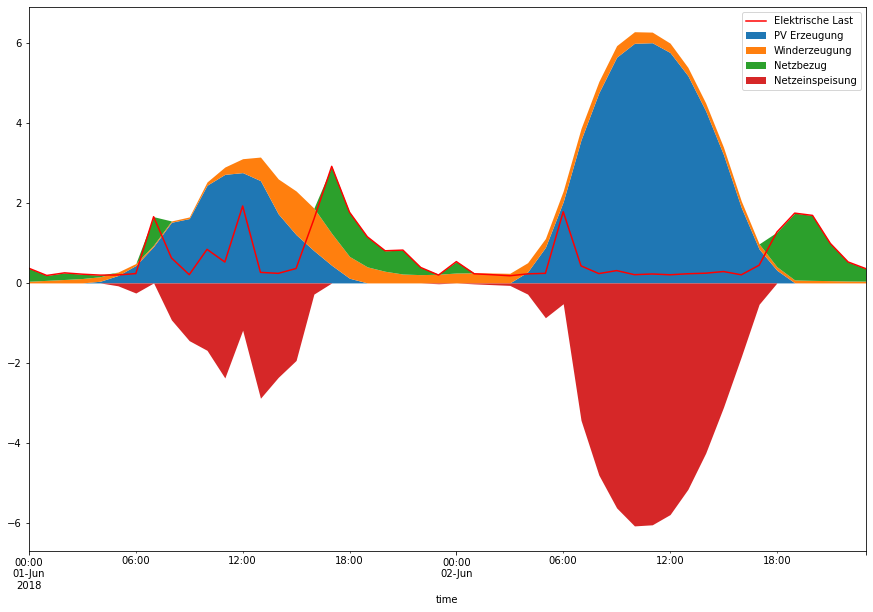

In [11]:
load_figure = network.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['06-01-18 00:00:00':'06-02-18 23:00:00'].plot(legend = True, color = 'red')
df_figure_base = pd.concat([network.generators_t.p['pv'],network.generators_t.p['wind'], network.generators_t.p['grid_import'], -network.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung','Winderzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc['06-01-18 00:00:00':'06-02-18 23:00:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)

# Erweiterung der Konfiguration

### Skizze der modifizierten Konfiguration
<img src="image/modified_system.png">
Abb. 2

## Wärmepumpe

In [12]:
#Netzwerk
network_wp = pypsa.Network()
network_wp.set_snapshots(pv_infeed.index)
network_wp.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 10 Minuten also 1/6 Stunde.

#Stromknoten definieren
network_wp.add("Bus", 
            name = "electricity")
#Wärmeknoten definieren
network_wp.add("Bus", 
            name = "thermal")
# Elektrische Last
network_wp.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)
# Thermische last
network_wp.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)
#PV-Anlage
network_wp.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Windanlage
network_wp.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network_wp.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])

#Netzbezug
network_wp.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
#Netzeinspeisung
network_wp.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

In [13]:
#Wärmepumpe
network_wp.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=3.2,
            efficiency = 3.5,       
           )

In [14]:
network_wp.lopf(solver_name = "cbc", pyomo = False)

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 0.89s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.80e+04


('ok', 'optimal')

In [15]:
# Ausführung der Auswertungsfunktion
results_wp, results_energy_wp = cost_share_evaluation(network_wp)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_wp["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_wp["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_wp["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_wp["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_wp["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_wp["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_wp["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_wp["Gesamtkosten"])/100,2))
      +"€.\n" 
       "Bei Beachtung der annuitätischen Kosten der neuen Komponente ergibt sich eine Kostenveränderung von "
      +str(round((-results_base["Gesamtkosten"]+results_wp["Gesamtkosten"])/100+420,2))
      +"€ pro Jahr."      )

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 81.13%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1084.4€ und EEG-Erlöse von 1076.39, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 479.59€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 12.15 Prozentpunkte und eine Verringerung der Kosten um 414.8€.
Bei Beachtung der annuitätischen Kosten der neuen Komponente ergibt sich eine Kostenveränderung von 5.2€ pro Jahr.


In [16]:
energy_figure = pd.DataFrame([results_energy_base, results_energy_wp], index = ['Basis', 'Mit Wärmepumpe'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh mit Wärmepumpe'}>

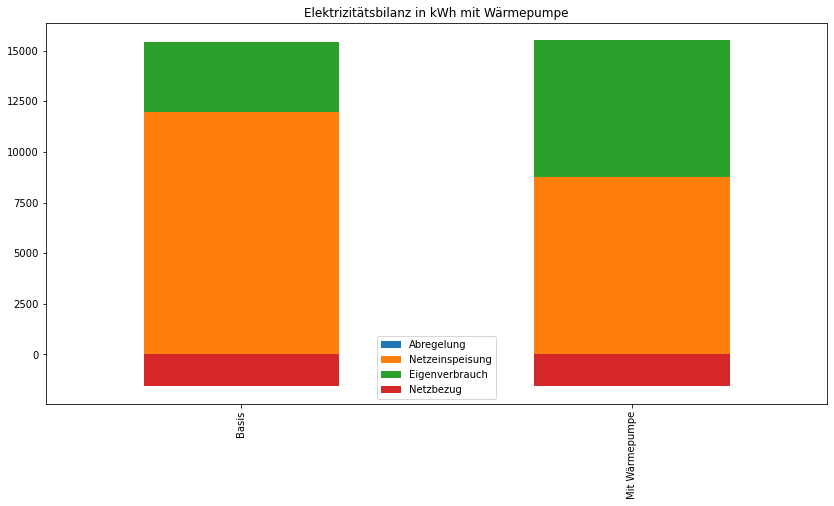

In [17]:
energy_figure.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh mit Wärmepumpe')

### Interpretation

Die Wärmepumpe sorgt für einen Anstieg des Eigenverbrauchsanteils, da sie den erzeugten Strom der Solaranlage direkt nutzen kann. Die Erhöhung des Eigenverbrauchs ist für den Anlagenbetreiber sinnvoller, da die eingesparten Kosten durch den Strombezug höher ausfallen als die vergütete Einspeisung in das Netz.Zudem sinken die Gasbezugskosten.
Allerdings weist das bestehende System schon einen relativ hohen Eigneverbauch auf, sodass üblich Werte von 30 bis 45 Prozent Steigerung bei einer Kombination einer Solaranlage und einer Wärmepumpe hier nicht erreicht werden können.
Bei der Auswahl der Wärmepumpe gilt es die Leistungsgröße zu beachten. In unserem Beispiel ...
Es zeigt sich zudem, dass während der Abschreibezeit der Wärmepumpe keine Gewinne erzielt werden können. Diese Zeit liegt circa bei 8,5 Jahren. Nach dieser Zeit lassen sich Gewinne in Höhe von ... erzielen.

## Batteriespeicher

In [18]:
#Netzwerk
network_bat = pypsa.Network()
network_bat.set_snapshots(pv_infeed.index)
network_bat.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 10 Minuten also 1/6 Stunde.

#Stromknoten definieren
network_bat.add("Bus", 
            name = "electricity")
#Wärmeknoten definieren
network_bat.add("Bus", 
            name = "thermal")
# Elektrische Last
network_bat.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)
# Thermische last
network_bat.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)
#PV-Anlage
network_bat.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Windanlage
network_bat.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network_bat.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])

#Netzbezug
network_bat.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
#Netzeinspeisung
network_bat.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

In [19]:
# Hilfsknoten
network_bat.add("Bus", 
            name = "storage_electricity")
#Einspeicherleistung vom Knoten "electricity" zum Knoten "storage_electricity"
network_bat.add("Link", 
            name = "electrical_storage_charge", 
            bus0 = "electricity", 
            bus1 = "storage_electricity", 
            p_nom = 2.4,
            efficiency = math.sqrt(0.85)
                    )
#Ausspeicherleistung vom Knoten "storage_electricity" zum Knoten "electricity"
network_bat.add("Link", 
            name = "electricity_storage_discharge", 
            bus0 = "storage_electricity", 
            bus1 = "electricity", 
            p_nom = 2.4,
            efficiency = math.sqrt(0.85)
                    )
#Speicher
network_bat.add("Store", 
            name = "electricity_storage", 
            bus = "storage_electricity", 
            e_nom = 8,         
            e_cyclic = True        # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            )

In [20]:
network_bat.lopf(solver_name = "cbc", pyomo = False)

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 6.72e+04


('ok', 'optimal')

In [21]:
# Ausführung der Auswertungsfunktion
results_bat, results_energy_bat = cost_share_evaluation(network_bat)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_bat["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_bat["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_bat["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_bat["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_bat["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_bat["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_bat["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_bat["Gesamtkosten"])/100,2))
      +"€.\n" 
       "Bei Beachtung der annuitätischen Kosten der neuen Komponente ergibt sich eine Kostenveränderung von "
      +str(round((-results_base["Gesamtkosten"]+results_bat["Gesamtkosten"])/100+900,2))
      +"€ pro Jahr."      )
    

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 95.81%.
 Dabei entstehen Stromkosten von 66.76€, Gaskosten von 1891.83€ und EEG-Erlöse von 1286.95, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 671.63€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 26.83 Prozentpunkte und eine Verringerung der Kosten um 222.76€.
Bei Beachtung der annuitätischen Kosten der neuen Komponente ergibt sich eine Kostenveränderung von 677.24€ pro Jahr.


In [22]:
energy_figure = pd.DataFrame([results_energy_base, results_energy_bat], index = ['Basis', 'Mit Batteriespeicher'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh mit Batteriespeicher'}>

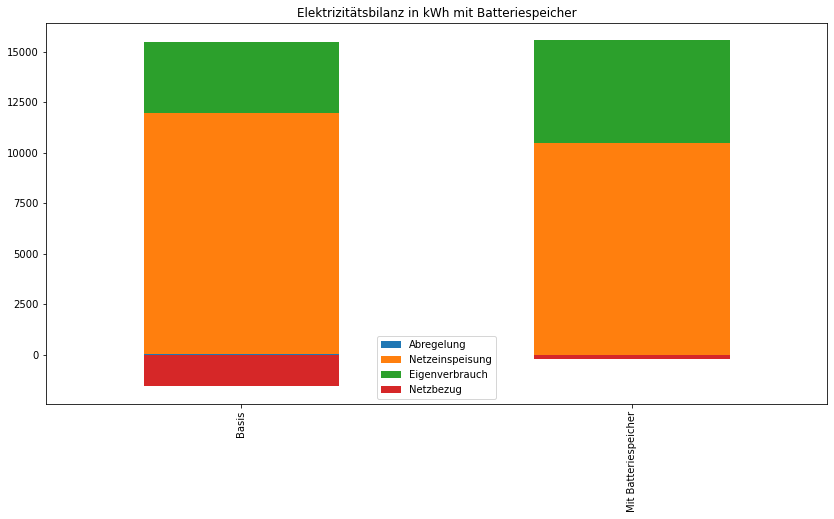

In [23]:
energy_figure.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh mit Batteriespeicher')

### Interpretation

Der Batteriespeicher sorgt im Vergleich zu der Wärmepumpe für eine höhere Steigerung des Eigenverbrauchanteils. Allerdings kann der Batteriespeicher nur elektrische Energie speichern, welches sich wirtschaftlich nur in der Reduzierung der Stromkosten äußert.
Die Batteriespeicher eignen sich am besten um Lastspitzen zu der Mittagszeit abzufangen, um eine zeitliche Verschiebung Erzeugung und Verbrauch zu schaffen.
Bei dem Batteriespeicher gilt ebenfalss, dass während der Abschreibezeit des Speichers keine Gewinne erzielt werden können. Bei der Annahme, dass der Stromspeicher pro Kilowattstunde-Kapazität 1000 Euro kosten würde, ergäbe sich eine Abschreibezeit von circa 9Jahren. Danach lassen sich jährlich Gewinne einfahren.

## thermischer Speicher

In [24]:
#Netzwerk
network_therm = pypsa.Network()
network_therm.set_snapshots(pv_infeed.index)
network_therm.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 10 Minuten also 1/6 Stunde.

#Stromknoten definieren
network_therm.add("Bus", 
            name = "electricity")
#Wärmeknoten definieren
network_therm.add("Bus", 
            name = "thermal")
# Elektrische Last
network_therm.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)
# Thermische last
network_therm.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)
#PV-Anlage
network_therm.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Windanlage
network_therm.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network_therm.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])

#Netzbezug
network_therm.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
#Netzeinspeisung
network_therm.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

In [25]:
# Hilfsknoten
network_therm.add("Bus", 
            name = "storage_thermal")
#Einspeicherleistung vom Knoten "thermal" zum Knoten "storage_thermal"
network_therm.add("Link", 
            name = "hot_water_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = 12)
#Ausspeicherleistung vom Knoten "storage_thermal" zum Knoten "thermal"
network_therm.add("Link", 
            name = "hot_water_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = 12)
#Speicher
network_therm.add("Store", 
            name = "hot_water_storage", 
            bus = "storage_thermal", 
            e_nom = 7, 
            e_cyclic = True) # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
                     

In [26]:
network_therm.lopf(solver_name = "cbc", pyomo = False)

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 0.94s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.94e+04


('ok', 'optimal')

In [27]:
# Ausführung der Auswertungsfunktion
results_therm, results_energy_therm = cost_share_evaluation(network_therm)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_therm["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_therm["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_therm["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_therm["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_therm["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_therm["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_therm["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_therm["Gesamtkosten"])/100,2))
      +"€.\n" 
       "Bei Beachtung der annuitätischen Kosten der neuen Komponente ergibt sich eine Kostenveränderung von "
      +str(round((-results_base["Gesamtkosten"]+results_therm["Gesamtkosten"])/100+100,2))
      +"€ pro Jahr."      )
     

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 68.98%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1891.83€ und EEG-Erlöse von 1469.02, wobei 0.1kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 894.4€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 0.0 Prozentpunkte und eine Verringerung der Kosten um 0.0€.
Bei Beachtung der annuitätischen Kosten der neuen Komponente ergibt sich eine Kostenveränderung von 100.0€ pro Jahr.


In [28]:
energy_figure = pd.DataFrame([results_energy_base, results_energy_therm], index = ['Basis', 'Mit thermischen Speicher'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh mit thermischen Speicher'}>

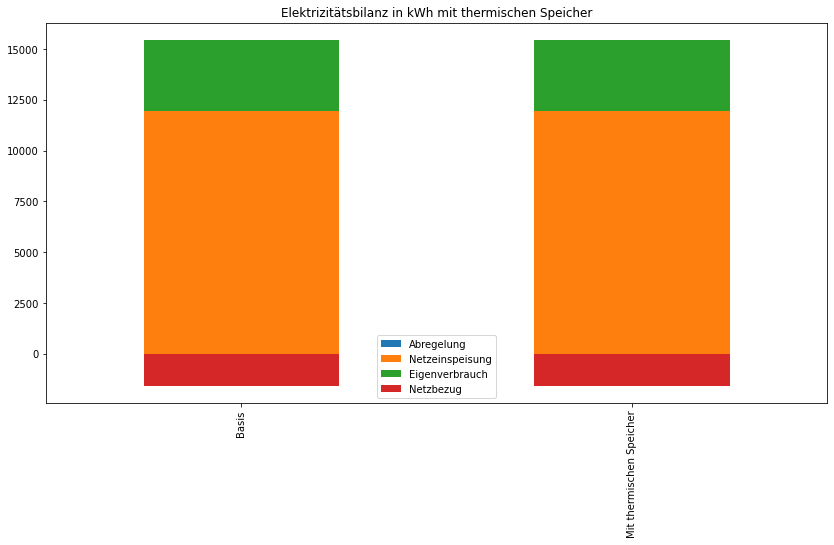

In [29]:
energy_figure.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh mit thermischen Speicher')

### Interpretation

Der thermische Speicher kann den Eigenverbrauchsanteil nicht verringern, da er den Stromanteil nicht bedienen kann. 
Die Simulation zeigt, dass der thermische Speicher als einzige ergänzende Komponenten zu keiner Kostenverringerung führt. 
Der thermische Speicher macht nur in Komination mit einer Wärmepumpe einen Sinn.

## Wärmepumpe mit Batteriespeicher

In [30]:
#Netzwerk
network_wpbat = pypsa.Network()
network_wpbat.set_snapshots(pv_infeed.index)
network_wpbat.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 10 Minuten also 1/6 Stunde.

#Stromknoten definieren
network_wpbat.add("Bus", 
            name = "electricity")
#Wärmeknoten definieren
network_wpbat.add("Bus", 
            name = "thermal")
# Elektrische Last
network_wpbat.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)
# Thermische last
network_wpbat.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)
#PV-Anlage
network_wpbat.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Windanlage
network_wpbat.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network_wpbat.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])

#Netzbezug
network_wpbat.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
#Netzeinspeisung
network_wpbat.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

In [31]:
#Wärmepumpe
network_wpbat.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=3.2,
            efficiency = 3.5       
           )

In [32]:
# Hilfsknoten
network_wpbat.add("Bus", 
            name = "storage_electricity")
#Einspeicherleistung vom Knoten "electricity" zum Knoten "storage_electricity"
network_wpbat.add("Link", 
            name = "electrical_storage_charge", 
            bus0 = "electricity", 
            bus1 = "storage_electricity", 
            p_nom = 2.4,
            efficiency = math.sqrt(0.85)
                    )
#Ausspeicherleistung vom Knoten "storage_electricity" zum Knoten "electricity"
network_wpbat.add("Link", 
            name = "electricity_storage_discharge", 
            bus0 = "storage_electricity", 
            bus1 = "electricity", 
            p_nom = 2.4,
            efficiency = math.sqrt(0.85)
                    )
#Speicher
network_wpbat.add("Store", 
            name = "electricity_storage", 
            bus = "storage_electricity", 
            e_nom = 8,         
            e_cyclic = True       # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            )

In [33]:
network_wpbat.lopf(solver_name = "cbc", pyomo = False)

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 0.95s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.04e+04


('ok', 'optimal')

In [34]:
# Ausführung der Auswertungsfunktion
results_wpbat, results_energy_wpbat = cost_share_evaluation(network_wpbat)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_wpbat["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_wpbat["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_wpbat["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_wpbat["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_wpbat["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_wpbat["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_wpbat["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_wpbat["Gesamtkosten"])/100,2))
      +"€.\n" 
       "Bei Beachtung der annuitätischen Kosten der neuen Komponente ergibt sich eine Kostenveränderung von "
      +str(round((-results_base["Gesamtkosten"]+results_wpbat["Gesamtkosten"])/100+900+420,2))
      +"€ pro Jahr."      )

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 97.62%.
 Dabei entstehen Stromkosten von 66.76€, Gaskosten von 929.9€ und EEG-Erlöse von 792.2, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 204.46€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 28.64 Prozentpunkte und eine Verringerung der Kosten um 689.94€.
Bei Beachtung der annuitätischen Kosten der neuen Komponente ergibt sich eine Kostenveränderung von 630.06€ pro Jahr.


In [35]:
energy_figure = pd.DataFrame([results_energy_base, results_energy_wpbat], index = ['Basis', 'Mit Wärmepumpe und Batterie'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh mit Wärmepumpe und Batterie'}>

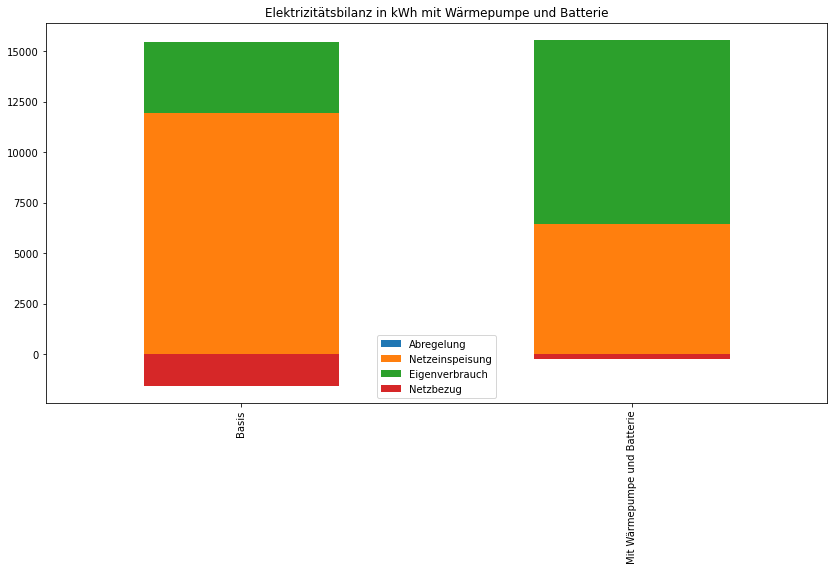

In [36]:
energy_figure.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh mit Wärmepumpe und Batterie')

### Interpretation

Die Kombination aus einer Wärmepumpe und einer Batterie sorgt für eine minimale Steigerung des Eigenverbrauchsanteils im Vergleich zu dem Batteriespeicher einzeln.
Allerdings erfolgen dadurch Einsparungen bei den Stromkosten und den Gasbezugskosten, sodass die höchsten Einsparungen im Vergleich zum Basissystem erzielt werden können.
In der hier dargestellten Abschreibezeit lassen sich keine Gewinne erzielen. 

## Wärmepumpe mit thermischen Speicher

In [37]:
#Netzwerk
network_wptherm = pypsa.Network()
network_wptherm.set_snapshots(pv_infeed.index)
network_wptherm.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 10 Minuten also 1/6 Stunde.

#Stromknoten definieren
network_wptherm.add("Bus", 
            name = "electricity")
#Wärmeknoten definieren
network_wptherm.add("Bus", 
            name = "thermal")
# Elektrische Last
network_wptherm.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)
# Thermische last
network_wptherm.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)
#PV-Anlage
network_wptherm.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Windanlage
network_wptherm.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network_wptherm.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])

#Netzbezug
network_wptherm.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
#Netzeinspeisung
network_wptherm.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

In [38]:
#Wärmepumpe
network_wptherm.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=3.2,
            efficiency = 3.5       
           )

In [39]:
# Hilfsknoten
network_wptherm.add("Bus", 
            name = "storage_thermal")
#Einspeicherleistung vom Knoten "thermal" zum Knoten "storage_thermal"
network_wptherm.add("Link", 
            name = "hot_water_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = 12)
#Ausspeicherleistung vom Knoten "storage_thermal" zum Knoten "thermal"
network_wptherm.add("Link", 
            name = "hot_water_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = 12)
#Speicher
network_wptherm.add("Store", 
            name = "hot_water_storage", 
            bus = "storage_thermal", 
            e_nom = 7, 
            e_cyclic = True) # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen

In [40]:
network_wptherm.lopf(solver_name = "cbc", pyomo = False)

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.35s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.02e+04


('ok', 'optimal')

In [41]:
# Ausführung der Auswertungsfunktion
results_wptherm, results_energy_wptherm = cost_share_evaluation(network_wptherm)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_wptherm["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_wptherm["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_wptherm["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_wptherm["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_wptherm["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_wptherm["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_wptherm["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_wptherm["Gesamtkosten"])/100,2))
      +"€.\n" 
       "Bei Beachtung der annuitätischen Kosten der neuen Komponente ergibt sich eine Kostenveränderung von "
      +str(round((-results_base["Gesamtkosten"]+results_wptherm["Gesamtkosten"])/100+100+420,2))
      +"€ pro Jahr."      )

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 82.39%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 936.34€ und EEG-Erlöse von 1006.22, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 401.71€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 13.41 Prozentpunkte und eine Verringerung der Kosten um 492.68€.
Bei Beachtung der annuitätischen Kosten der neuen Komponente ergibt sich eine Kostenveränderung von 27.32€ pro Jahr.


In [42]:
energy_figure = pd.DataFrame([results_energy_base, results_energy_wptherm], index = ['Basis', 'Mit Wärmepumpe und thermischen Speicher'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh mit Wärmepumpe und thermischen Speicher'}>

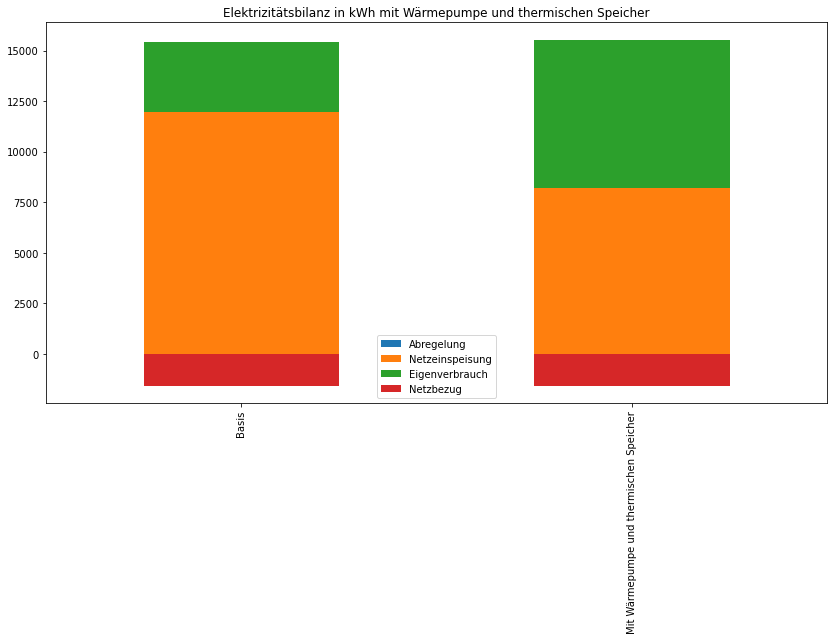

In [43]:
energy_figure.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh mit Wärmepumpe und thermischen Speicher')

###Interpretation

Die Kombination aus einer Wärmepumpe und einem thermischen Speicher zeigt, dass die Gasbezugskosten noch weiter gesenkt werden können im Vergleich zu der Wärmepumpe einzeln.
Allerdings sind diese ziemlich gering, sodass in der Abschreibzeit mit erhöhten Kosten zu rechnen ist.

## Gesamtsystem

In [44]:
#Netzwerk
network_modified = pypsa.Network()
network_modified.set_snapshots(pv_infeed.index)
network_modified.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 10 Minuten also 1/6 Stunde.

#Stromknoten definieren
network_modified.add("Bus", 
            name = "electricity")
#Wärmeknoten definieren
network_modified.add("Bus", 
            name = "thermal")
# Elektrische Last
network_modified.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)
# Thermische last
network_modified.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)
#PV-Anlage
network_modified.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Windanlage
network_modified.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network_modified.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])

#Netzbezug
network_modified.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
#Netzeinspeisung
network_modified.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.


In [45]:
#Wärmepumpe
network_modified.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=3.2,
            efficiency = 3.5      
           )

In [46]:
# Batteriespeicher
# Hilfsknoten
network_modified.add("Bus", 
            name = "storage_electricity")
#Einspeicherleistung vom Knoten "electricity" zum Knoten "storage_electricity"
network_modified.add("Link", 
            name = "electrical_storage_charge", 
            bus0 = "electricity", 
            bus1 = "storage_electricity", 
            p_nom = 2.4,
            efficiency = math.sqrt(0.85)
                    )
#Ausspeicherleistung vom Knoten "storage_electricity" zum Knoten "electricity"
network_modified.add("Link", 
            name = "electricity_storage_discharge", 
            bus0 = "storage_electricity", 
            bus1 = "electricity", 
            p_nom = 2.4,
            efficiency = math.sqrt(0.85)
                    )
#Speicher
network_modified.add("Store", 
            name = "electricity_storage", 
            bus = "storage_electricity", 
            e_nom = 8,         
            e_cyclic = True       # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            )

In [47]:
# Hilfsknoten
network_modified.add("Bus", 
            name = "storage_thermal")
#Einspeicherleistung vom Knoten "thermal" zum Knoten "storage_thermal"
network_modified.add("Link", 
            name = "hot_water_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = 12)
#Ausspeicherleistung vom Knoten "storage_thermal" zum Knoten "thermal"
network_modified.add("Link", 
            name = "hot_water_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = 12)
#Speicher
network_modified.add("Store", 
            name = "hot_water_storage", 
            bus = "storage_thermal", 
            e_nom = 7, 
            e_cyclic = True      ) # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
                     

## Simulation der erweiterten Konfiguration

In [48]:
# Simulation für den kompletten Zeitraum:
network_modified.lopf(solver_name = "cbc", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.38s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.57e+04


('ok', 'optimal')

In [49]:
# Ausführung der Auswertungsfunktion
results_with_modification, results_energy_with_modification = cost_share_evaluation(network_modified)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_with_modification["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_with_modification["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_with_modification["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_with_modification["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_with_modification["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_with_modification["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_with_modification["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_with_modification["Gesamtkosten"])/100,2))
      +"€.\n" 
       "Bei Beachtung der annuitätischen Kosten der neuen Komponente ergibt sich eine Kostenveränderung von "
      +str(round((-results_base["Gesamtkosten"]+results_with_modification["Gesamtkosten"])/100+420+100+900,2))
      +"€ pro Jahr."      )
     

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 97.69%.
 Dabei entstehen Stromkosten von 66.76€, Gaskosten von 844.12€ und EEG-Erlöse von 753.82, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 157.06€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 28.71 Prozentpunkte und eine Verringerung der Kosten um 737.34€.
Bei Beachtung der annuitätischen Kosten der neuen Komponente ergibt sich eine Kostenveränderung von 682.66€ pro Jahr.


### Interpretation

Bei Betrachtung der Modifikation mit allen drei Optionen lässt sich die höchste Kostenverringerung im Vergleich zum Basismodell annehmen. Diese ist jedoch nur marginal höher als bei der Kombination aus Wärmepumpe und Batteriespeicher. 

## Visualisierung des Vergleichs

<AxesSubplot:xlabel='time'>

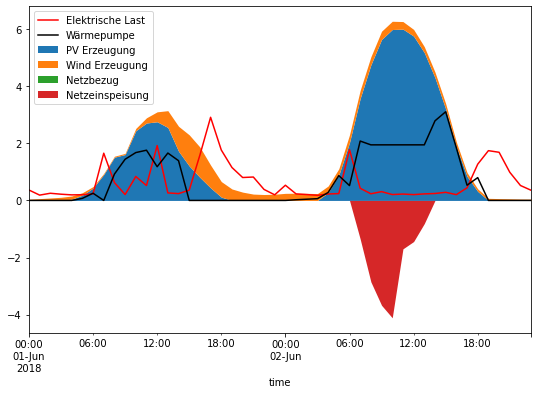

In [50]:
total_load = pd.concat([network_modified.loads_t.p_set['electricity_load'], network_modified.links_t.p0['heat_pump']], axis = 1)
total_load.columns = ['Elektrische Last', 'Wärmepumpe']
ax = total_load.loc['06-01-18 00:00:00':'06-02-18 23:00:00'].plot(color = ['red', 'black'], legend = True, stacked = False)

df_figure_with_modification = pd.concat([network_modified.generators_t.p['pv'], network_modified.generators_t.p['wind'], network_modified.generators_t.p['grid_import'], -network_modified.generators_t.p['grid_export']], axis = 1)
df_figure_with_modification.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_with_modification.loc['06-01-18 00:00:00':'06-02-18 23:00:00'].plot(subplots = False, figsize=(9,6), kind= 'area', linewidth=0, ax = ax)

In [51]:
energy_figure = pd.DataFrame([results_energy_base, results_energy_with_modification], index = ['Basis', 'Mit Modifikation'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh mit allen drei Optionen'}>

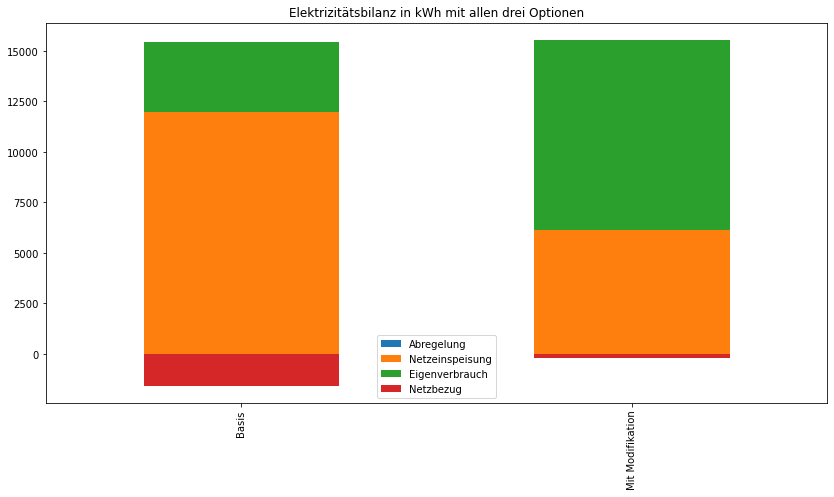

In [52]:
energy_figure.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh mit allen drei Optionen')

## Grenzen der Simulationsmodellierung

1. keine Abbildung nach der Abschreibezeit
2. keine laufenden Kosten abgebildet, wie z.B. Wartungsarbeitskosten
3. kein reales Verhalten der Betriebsmittel
4. keine Abbildung von sich ändernenden Lasten